In [1]:
import nltk
import spacy
import string
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import *

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

from helpers import *
from dataset import *

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(threshold=sys.maxsize)

# Download stopwords if required
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tobias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TRAIN_WORD2VEC = True

In [3]:
train_df = load_news_dataset()
#train_df = load_news_dataset()

train_df = train_df[:50000]

In [4]:
CLASSNAMES = np.unique(train_df['category'])
CLASSES = len(CLASSNAMES)
train_df.head()

,id,category,headline,authors,link,short_description,date
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
print('Entries: {}'.format(len(train_df)))
print('Categories: {}'.format(CLASSES))
print(CLASSNAMES)

Entries: 50000
Categories: 31
['ARTS' 'ARTS & CULTURE' 'BLACK VOICES' 'BUSINESS' 'COLLEGE' 'COMEDY'
 'CRIME' 'EDUCATION' 'ENTERTAINMENT' 'FIFTY' 'GOOD NEWS' 'GREEN'
 'HEALTHY LIVING' 'IMPACT' 'LATINO VOICES' 'MEDIA' 'PARENTS' 'POLITICS'
 'QUEER VOICES' 'RELIGION' 'SCIENCE' 'SPORTS' 'STYLE' 'TASTE' 'TECH'
 'THE WORLDPOST' 'TRAVEL' 'WEIRD NEWS' 'WOMEN' 'WORLD NEWS' 'WORLDPOST']


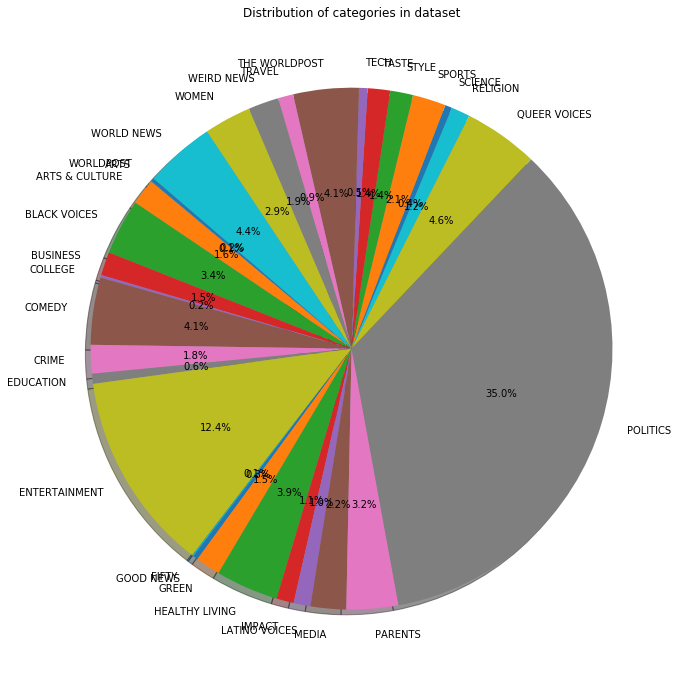

In [6]:
pie_data = []
for cn in CLASSNAMES:
    pie_data.append(train_df[train_df.category == cn].count()[0])
    
plt.figure(figsize=(15, 12))
plt.pie(pie_data, labels=CLASSNAMES, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of categories in dataset')
plt.show()

#### Keep Top k Categories

In [7]:
top_k = 10
top_k_categories = train_df['category'].value_counts()[:top_k].index.tolist()
print('Top {} categories: {}'.format(top_k, top_k_categories))

Top 10 categories: ['POLITICS', 'ENTERTAINMENT', 'QUEER VOICES', 'WORLD NEWS', 'COMEDY', 'THE WORLDPOST', 'HEALTHY LIVING', 'BLACK VOICES', 'PARENTS', 'WOMEN']


In [8]:
train_df = train_df[train_df['category'].isin(top_k_categories)]

In [9]:
CLASSNAMES = np.unique(train_df['category'])
CLASSES = len(CLASSNAMES)

print('Entries: {}'.format(len(train_df)))
print('Categories: {}'.format(CLASSES))
print(CLASSNAMES)

Entries: 39035
Categories: 10
['BLACK VOICES' 'COMEDY' 'ENTERTAINMENT' 'HEALTHY LIVING' 'PARENTS'
 'POLITICS' 'QUEER VOICES' 'THE WORLDPOST' 'WOMEN' 'WORLD NEWS']


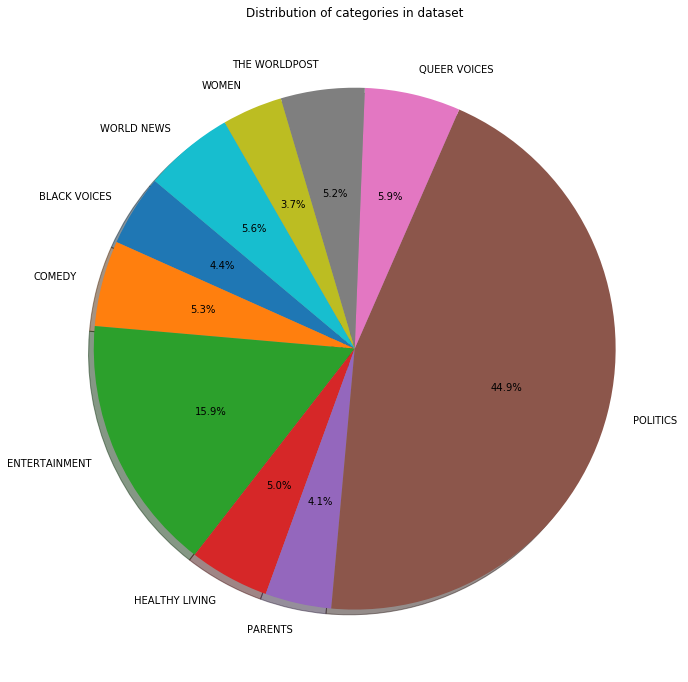

In [10]:
pie_data = []
for cn in CLASSNAMES:
    pie_data.append(train_df[train_df.category == cn].count()[0])
    
plt.figure(figsize=(15, 12))
plt.pie(pie_data, labels=CLASSNAMES, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of categories in dataset')
plt.show()

In [11]:
test_sentence = train_df['headline'].iloc[10]
test_sentence

"Trump's Crackdown On Immigrant Parents Puts More Kids In An Already Strained System"

In [12]:
all_words = ' '.join([text for text in train_df['headline']])
print('Number of words in all_words:', len(all_words))

Number of words in all_words: 2591077


### Wordcloud

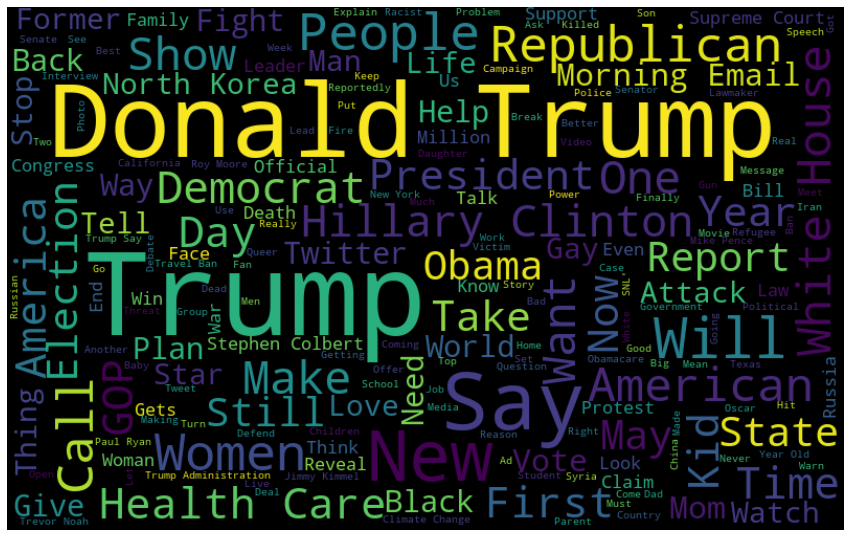

In [13]:
plot_wordcloud(train_df['headline'])

## Text Preprocessing

In [14]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
def clean_text(x, stemming=True):
    """
    clean text x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of cleaned data without stopwords, to lower, etc.
    """    
    stemmer = PorterStemmer()
    
    cleaned = []
    for text in x:
        tokens = text.split()
        tokens = [tok.lower().strip() for tok in tokens]
        
        # Remove Stopwords
        tokens = [tok for tok in tokens if tok not in stop_words and tok not in string.punctuation]
        
        # Stemming
        if stemming:
            tokens = [stemmer.stem(tok) for tok in tokens]
        
        tokens = ' '.join(tokens)
        cleaned.append(tokens)
    return cleaned

In [16]:
print(test_sentence)
print(clean_text([test_sentence], stemming=False))
print(clean_text([test_sentence], stemming=True))

Trump's Crackdown On Immigrant Parents Puts More Kids In An Already Strained System
["trump's crackdown immigrant parents puts kids already strained system"]
["trump' crackdown immigr parent put kid alreadi strain system"]


#### Create Vocabulary

In [17]:
vocabulary = np.unique(clean_text(train_df['headline']))
vocabulary_size = len(vocabulary)

In [18]:
def tokenize(x, tokenizer=None):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    if tokenizer is None:
        x_tk = Tokenizer()
        x_tk.fit_on_texts(x)
    else:
        x_tk = tokenizer

    return x_tk.texts_to_sequences(x), x_tk
    
text_tokenized, text_tokenizer = tokenize([test_sentence])
print(test_sentence)
print(text_tokenizer.word_index)
print(text_tokenized)

Trump's Crackdown On Immigrant Parents Puts More Kids In An Already Strained System
{"trump's": 1, 'crackdown': 2, 'on': 3, 'immigrant': 4, 'parents': 5, 'puts': 6, 'more': 7, 'kids': 8, 'in': 9, 'an': 10, 'already': 11, 'strained': 12, 'system': 13}
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]


In [19]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    if length is None:
        length = max([len(sentence) for sentence in x])
        
    return pad_sequences(x, maxlen=length, padding='post', dtype='float32'), length

text_padding, _ = pad(text_tokenized, 20)
text_padding

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [20]:
def preprocess(x, tokenizer=None, padding=None):
    """
    Preprocess x
    :param x: Feature List of sentences
    :return: Tuple of (Preprocessed x, x tokenizer)
    """
    preprocess_x = clean_text(x)
    
    preprocess_x, _ = tokenize(preprocess_x, tokenizer)
    preprocess_x, pad_length = pad(preprocess_x, length=padding)
    
    return preprocess_x, pad_length

### Train/Test split

In [21]:
X = list(train_df['headline'])
y = list(train_df['category'])

In [22]:
label_encoder = LabelEncoder()
class_labels = label_encoder.fit(CLASSNAMES)

In [23]:
MAX_FEATURES = 2000
tokenizer = Tokenizer(num_words=MAX_FEATURES, split=' ')
tokenizer.fit_on_texts(vocabulary)

In [24]:
MAX_SEQUENCE_LEN = 20
X, padding = preprocess(X, tokenizer=tokenizer, padding=MAX_SEQUENCE_LEN)
y = to_categorical(label_encoder.transform(y))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
max_words = len(X_train[0]) # length of largest sentence
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(sentence) for sentence in X])
num_classes = CLASSES

In [27]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_df['category']),
                                                 train_df['category'])
class_weights

array([2.26552525, 1.88120482, 0.62990157, 2.01315111, 2.4366417 ,
       0.22282795, 1.68399482, 1.92575234, 2.67546265, 1.79306385])

## Train Word2Vec

In [28]:
WORD_VECTOR_DIMENSION = 200

In [29]:
w2v_model = Word2Vec(size=WORD_VECTOR_DIMENSION, min_count=5)
w2v_model.build_vocab(vocabulary)
w2v_model.train(vocabulary, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

(1853989, 9492070)

In [30]:
BATCH_SIZE = 16
EPOCHS = 10

In [31]:
embedding_matrix = np.zeros((vocabulary_size, WORD_VECTOR_DIMENSION))
for word, i in tokenizer.word_index.items():
    if i>=max_words:
        continue
    try:
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), WORD_VECTOR_DIMENSION)

del w2v_model

In [55]:
from tensorflow.keras.layers import GRU, SpatialDropout1D, Reshape, Conv2D, MaxPool2D, Concatenate
from tensorflow.keras.models import Model

def best_model():
    model = Sequential()    
    model.add(Embedding(MAX_FEATURES, WORD_VECTOR_DIMENSION, 
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=max_length,
                                trainable=True))
    model.add(Conv1D(filters=256, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mse', 'accuracy'])
    
    return model

def test_model():
    inputs = Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')
    embedding = Embedding(input_dim=vocabulary_size, output_dim=WORD_VECTOR_DIMENSION, input_length=MAX_SEQUENCE_LEN)(inputs)
    reshape = Reshape((MAX_SEQUENCE_LEN, WORD_VECTOR_DIMENSION, 1))(embedding)

    filter_sizes = [3,4,5]
    
    conv_0 = Conv2D(512, kernel_size=(filter_sizes[0], WORD_VECTOR_DIMENSION), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_1 = Conv2D(512, kernel_size=(filter_sizes[1], WORD_VECTOR_DIMENSION), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_2 = Conv2D(512, kernel_size=(filter_sizes[2], WORD_VECTOR_DIMENSION), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(0.5)(flatten)
    output = Dense(units=num_classes, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=output)    
    
    #optimizer = Adam(lr=1e-4)
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mse', 'accuracy'])
    
    return model

model = test_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 20, 200)      7784000     input_22[0][0]                   
__________________________________________________________________________________________________
reshape_17 (Reshape)            (None, 20, 200, 1)   0           embedding_17[0][0]               
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 18, 1, 512)   307712      reshape_17[0][0]                 
____________________________________________________________________________________________

In [ ]:
def train_word2vec():
    checkpoint = ModelCheckpoint('model_word2vec.h5', verbose=1, save_best_only=True, save_weights_only=False)
    earlystopping = EarlyStopping(patience=5, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, min_delta=0.000001)
    
    logdir = './logs/' + time.strftime("%Y%m%d_%H%M%S")
    os.mkdir(logdir)
    tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_images=True, profile_batch = 100000000)    

    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2, 
                        callbacks=[checkpoint, earlystopping, tensorboard, reduce_lr],
                        class_weight=class_weights)
    
    score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
    print(score)
    
    plot_history(history)
    
if TRAIN_WORD2VEC:
    train_word2vec()
else:    
    model = load_model('model_word2vec.h5')
    

Train on 24982 samples, validate on 6246 samples
Epoch 1/10
24976/24982 [============================>.] - ETA: 0s - loss: 1.6563 - mse: 0.0676 - accuracy: 0.4876
Epoch 00001: val_loss improved from inf to 1.40671, saving model to model_word2vec.h5
24982/24982 [==============================] - 114s 5ms/sample - loss: 1.6564 - mse: 0.0676 - accuracy: 0.4876 - val_loss: 1.4067 - val_mse: 0.0576 - val_accuracy: 0.5565
Epoch 2/10
24976/24982 [============================>.] - ETA: 0s - loss: 1.1828 - mse: 0.0499 - accuracy: 0.6267
Epoch 00002: val_loss improved from 1.40671 to 1.07612, saving model to model_word2vec.h5
24982/24982 [==============================] - 116s 5ms/sample - loss: 1.1826 - mse: 0.0499 - accuracy: 0.6268 - val_loss: 1.0761 - val_mse: 0.0462 - val_accuracy: 0.6659
Epoch 3/10
24976/24982 [============================>.] - ETA: 0s - loss: 0.9369 - mse: 0.0415 - accuracy: 0.7023
Epoch 00003: val_loss improved from 1.07612 to 0.97100, saving model to model_word2vec.h5
2

In [ ]:
test_sentence = 'Justin Timberlake Visits Texas School Shooting Victims'
preprocessed_test_sentence = preprocess([test_sentence], tokenizer, padding=MAX_SEQUENCE_LEN)[0]
print(preprocessed_test_sentence)
print(X_train[0])

print('Text: {}\n'.format(test_sentence))

prediction = model.predict(preprocessed_test_sentence)[0]                          
print('Prediction Value: {}'.format(np.argmax(prediction)))

prediction = np.argmax(prediction)
print("Prediction Text: {}".format(CLASSNAMES[prediction]))

In [ ]:
# Bar Chart mit den % Zahlen hinzufügen